In [84]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from time import time
from sklearn import metrics

In [2]:
DATA_RAW_PATH = "data/data.parquet"
DATA_LABELS_PATH = "data/labels.csv"

data = pd.read_parquet(DATA_RAW_PATH)
print(data.head())
print('data shape:',data.shape)
print(data.info())
#print('num of machines', len(set(data.MachineId)))
#print(set(data.MachineId))

labels = pd.read_csv(DATA_LABELS_PATH)
#print('labels cols:',labels.columns)
#print(labels['PumpFailed'].value_counts())
#print(labels['SlowStart'].value_counts())
#print(labels['SlowEnd'].value_counts())
print('-=========================-'*3)
print(labels.head())
print('labels shape:',labels.shape)
print(labels.info())

  MachineId  MeasurementId  Pressure
0     0_0_0              0       0.0
1     0_0_0              0       0.0
2     0_0_0              0       0.0
3     0_0_0              0       0.0
4     0_0_0              0       0.0
data shape: (18466364, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB
None
-=========================--=========================--=========================-
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0     0_0_0              0      False     False   False
1     0_0_1             -1        NaN       NaN     NaN
2     0_0_2              0      False     False   False
3     0_0_3              0       True     False   False
4     0_1_0             -1        NaN       NaN     NaN
labels shap

In [6]:
gdf = data[data.Pressure==0].groupby(['MachineId','MeasurementId']
                                    ).size().reset_index(name='counts_p0').sort_values(['counts_p0'])
gdf.head()

,MachineId,MeasurementId,counts_p0
18600,4_1_1,6290,71
21420,4_2_3,2819,71
20442,4_2_1,2819,72
6210,0_2_1,6375,75
13935,33_1_1,2155,75


In [29]:
## define new cols from grouped data based on their statistics
df_grouped = data[data.Pressure>0].groupby(['MachineId','MeasurementId'], as_index=False).agg(
                                                                    p_mean = ('Pressure', np.mean),
                                                                    p_median = ('Pressure', np.median),
                                                                    p_std = ('Pressure', np.std),
                                                                    p_var = ('Pressure', np.var),
                                                                    p_sum = ('Pressure', np.sum),
                                                                    p_count = ('Pressure', pd.Series.count)
                                                                )
# 'p_mean':np.mean, 'p_meadian':np.median, 'p_std':np.std, 'p_var':np.var, 'p_sum':np.sum, 'p_count':pd.Series.count
df_grouped = df_grouped.merge(gdf, left_on=['MachineId','MeasurementId'], right_on=['MachineId','MeasurementId'])
## drop value with one value => nan statistics
df_grouped.drop(19489, axis=0, inplace=True)
#### data with MeasurementId == -1 seems a bit wierd
df_grouped.drop(df_grouped[df_grouped.MeasurementId == -1].index, axis=0, inplace=True)
df_grouped.head()

,MachineId,MeasurementId,p_mean,p_median,p_std,p_var,p_sum,p_count,counts_p0
1,0_0_0,0,1.014906,1.080583,0.349993,0.122495,138.027184,136,232
2,0_0_0,215,1.354823,1.467253,0.372200,0.138533,260.126100,192,540
3,0_0_0,237,1.319532,1.450188,0.431919,0.186554,294.255639,223,366
4,0_0_0,353,0.779569,0.778426,0.191767,0.036775,167.607386,215,134
5,0_0_0,411,1.064425,1.144124,0.462432,0.213843,182.016630,171,202


<AxesSubplot:title={'center':'p>0 count'}, xlabel='MeasurementId', ylabel='p_count'>

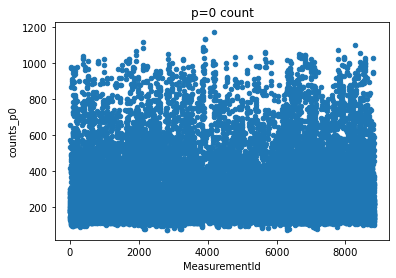

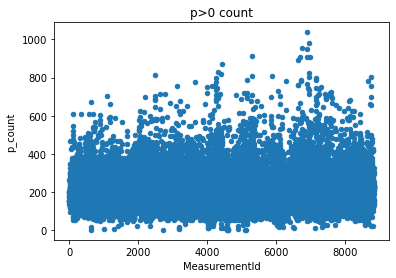

In [59]:
df_grouped[df_grouped.MeasurementId > -1].plot(kind='scatter', x = 'MeasurementId', y = 'counts_p0', title='p=0 count') # y = 'counts_p0')
df_grouped[df_grouped.MeasurementId > -1].plot(kind='scatter', x = 'MeasurementId', y = 'p_count', title='p>0 count') # y = 'counts_p0')

In [60]:
df_grouped.sort_values(['counts_p0'], ascending=True)

,MachineId,MeasurementId,p_mean,p_median,p_std,p_var,p_sum,p_count,counts_p0
21384,4_2_3,2819,0.885756,0.904131,0.150300,0.022590,219.667373,248,71
18564,4_1_1,6290,1.068098,1.090994,0.164718,0.027132,201.870544,189,71
20406,4_2_1,2819,0.482843,0.497709,0.108162,0.011699,119.262145,247,72
6201,0_2_1,6375,0.979620,0.959119,0.175126,0.030669,281.150943,287,75
13907,33_1_1,2155,0.673451,0.793501,0.324637,0.105389,193.953878,288,75
...,...,...,...,...,...,...,...,...,...
13628,2_2_3,8271,0.579466,0.631438,0.167114,0.027927,55.628755,96,1100
12276,25_2_2,2134,1.036897,1.280038,0.501672,0.251675,89.173132,86,1113
9989,14_1_0,3916,1.187638,1.269231,0.317914,0.101069,72.445946,61,1131
10275,14_1_2,3916,1.113144,1.234556,0.348928,0.121751,66.788610,60,1132


In [63]:
df_gm = df_grouped.merge(labels, on=['MachineId','MeasurementId'])
df_gm.dropna(subset=['PumpFailed'], inplace=True) # , axis=0, how='any'
df_gm.replace({False: 0, True: 1}, inplace=True)

In [64]:
df_gm.head()

,MachineId,MeasurementId,p_mean,p_median,p_std,p_var,p_sum,p_count,counts_p0,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,1.014906,1.080583,0.349993,0.122495,138.027184,136,232,0,0.0,0.0
1,0_0_0,215,1.354823,1.467253,0.372200,0.138533,260.126100,192,540,0,0.0,0.0
2,0_0_0,237,1.319532,1.450188,0.431919,0.186554,294.255639,223,366,0,0.0,1.0
3,0_0_0,353,0.779569,0.778426,0.191767,0.036775,167.607386,215,134,0,0.0,0.0
4,0_0_0,411,1.064425,1.144124,0.462432,0.213843,182.016630,171,202,1,0.0,0.0


In [67]:
for col in df_gm.columns:
    print(col, 'num of nans:', df_gm[col].isna().sum())
    
df_gm[df_gm['p_std'].isna()]

MachineId num of nans: 0
MeasurementId num of nans: 0
p_mean num of nans: 0
p_median num of nans: 0
p_std num of nans: 0
p_var num of nans: 0
p_sum num of nans: 0
p_count num of nans: 0
counts_p0 num of nans: 0
PumpFailed num of nans: 0
SlowStart num of nans: 0
SlowEnd num of nans: 0


,MachineId,MeasurementId,p_mean,p_median,p_std,p_var,p_sum,p_count,counts_p0,PumpFailed,SlowStart,SlowEnd


In [69]:
df_gm.dropna(subset=['SlowStart'], inplace=True)

In [70]:
df_gm.columns

Index(['MachineId', 'MeasurementId', 'p_mean', 'p_median', 'p_std', 'p_var',
       'p_sum', 'p_count', 'counts_p0', 'PumpFailed', 'SlowStart', 'SlowEnd'],
      dtype='object')

In [76]:
####### now we have clean data
features = ['p_mean', 'p_median', 'p_std', 'p_var','p_sum', 'p_count', 'counts_p0', 'SlowStart', 'SlowEnd'] 
target = ['PumpFailed']

X_train, X_test, y_train, y_test = train_test_split(df_gm[features], df_gm[target], test_size=0.3, random_state=666)
print("train: \n", y_train.value_counts())
print("test: \n", y_test.value_counts())

train: 
 PumpFailed
0             11910
1              1555
dtype: int64
test: 
 PumpFailed
0             5167
1              605
dtype: int64


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

RFC_GRID = {
    'loss' : ['exponential'],
    #'learning_rate' : [0.1, 0.5, 1],
    'learning_rate' : [0.1],
    #'n_estimators': [10, 50, 200],
    'n_estimators': [10],
    'criterion' : ['friedman_mse'], #, 'squared_error', 'mae'],
    'max_features' : ['auto']
    ##,'verbose' : [True]
    }

t = time()
model_rfc = make_pipeline(
    StandardScaler(),
    GridSearchCV(GradientBoostingClassifier(random_state = 666), param_grid=RFC_GRID, cv=5, refit=True) ### set: refit=True!!!
)
model_rfc.fit(X_train, y_train.values.ravel())
training_time = time() - t
model_rfc_y_pred = model_rfc.predict(X_test)

print(metrics.classification_report(y_test, model_rfc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_rfc[1].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_rfc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_rfc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      5167
           1       0.00      0.00      0.00       605

    accuracy                           0.90      5772
   macro avg       0.45      0.50      0.47      5772
weighted avg       0.80      0.90      0.85      5772

#########################------------------------------
training time: 1.9 s
------------------------------
model_sgdc.best_params_ {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_features': 'auto', 'n_estimators': 10}
------------------------------
accuracy 0.8951836451836452
------------------------------
confusion matrix:
[[5167    0]
 [ 605    0]]
#########################------------------------------


C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mirek\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer

SGDC_GRID = {'fit_intercept': [True, False],
             'early_stopping': [True, False],
             'loss': ['hinge', 'log', 'squared_hinge', 
                      'modified_huber', 'perceptron', 
                      'squared_error', 'huber', 'epsilon_insensitive', 
                      'squared_epsilon_insensitive'],                                       
             'penalty': ['l2', 'l1', 'none']
             }

t = time()
model_sgdc = make_pipeline(
    StandardScaler(),
    #Normalizer(),
    ## try different scoring metrics
    ## scoring = ['accuracy', 'accuracy_score', 'balanced_accuracy', 'balanced_accuracy_score', 'top_k_accuracy', 
    ## 'top_k_accuracy_score', 'average_precision', 'average_precision_score', 'neg_brier_score', 'brier_score_loss', 'f1']   
    GridSearchCV(SGDClassifier(random_state=666, class_weight='balanced',max_iter=10000), 
                 param_grid=SGDC_GRID, cv=5, 
                 scoring='f1', 
                 refit=True)
    
    #GridSearchCV(SGDClassifier(random_state=666, max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) 
)
model_sgdc.fit(X_train, y_train.values.ravel())
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[1].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      5167
           1       0.29      0.78      0.42       605

    accuracy                           0.77      5772
   macro avg       0.63      0.77      0.64      5772
weighted avg       0.90      0.77      0.81      5772

#########################------------------------------
training time: 29.2 s
------------------------------
model_sgdc.best_params_ {'early_stopping': False, 'fit_intercept': True, 'loss': 'log', 'penalty': 'l1'}
------------------------------
accuracy 0.7732155232155232
------------------------------
confusion matrix:
[[3993 1174]
 [ 135  470]]
#########################------------------------------


#              precision    recall  f1-score   support

           0       0.96      0.74      0.84      5167
           1       0.25      0.72      0.37       605

    accuracy                           0.74      5772
   macro avg       0.60      0.73      0.60      5772
weighted avg       0.88      0.74      0.79      5772

#########################------------------------------
training time: 15.2 s
------------------------------
model_sgdc.best_params_ {'early_stopping': False, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
------------------------------
accuracy 0.742030492030492
------------------------------
confusion matrix:
[[3848 1319]
 [ 170  435]]
#########################------------------------------

In [113]:
from sklearn.ensemble import RandomForestClassifier

RFC_GRID = {
    'n_estimators': [10, 50, 200, 500],
    'max_features': ['auto'],  ## , 'sqrt', 'log2'
    'max_depth' : [4,6,8],
    'criterion' :['entropy','gini'],
    }
'''
RFC_GRID = {'criterion': ['entropy'], 
            'max_depth': [8],
            'max_features': ['auto'], 
            'n_estimators': [200]
           }
'''

t = time()
model_sgdc = make_pipeline(
    #StandardScaler(),
    #Normalizer(),
    ## try different scoring metrics
    ## scoring = ['accuracy', 'accuracy_score', 'balanced_accuracy', 'balanced_accuracy_score', 'top_k_accuracy', 
    ## 'top_k_accuracy_score', 'average_precision', 'average_precision_score', 'neg_brier_score', 'brier_score_loss', 'f1']   
    GridSearchCV(RandomForestClassifier(random_state=666), #, class_weight='balanced'), 
                 param_grid=RFC_GRID, cv=5, 
                 scoring='f1', 
                 refit=True)
    
    #GridSearchCV(SGDClassifier(random_state=666, max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) 
)
model_sgdc.fit(X_train, y_train.values.ravel())
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[0].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5167
           1       0.72      0.22      0.34       605

    accuracy                           0.91      5772
   macro avg       0.82      0.60      0.64      5772
weighted avg       0.89      0.91      0.89      5772

#########################------------------------------
training time: 365.5 s
------------------------------
model_sgdc.best_params_ {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
------------------------------
accuracy 0.909043659043659
------------------------------
confusion matrix:
[[5114   53]
 [ 472  133]]
#########################------------------------------


   precision    recall  f1-score   support

           0       0.92      0.99      0.95      5167
           1       0.72      0.22      0.34       605

    accuracy                           0.91      5772
   macro avg       0.82      0.60      0.64      5772
weighted avg       0.89      0.91      0.89      5772

#########################------------------------------
training time: 365.5 s
------------------------------
model_sgdc.best_params_ {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
------------------------------
accuracy 0.909043659043659
------------------------------
confusion matrix:
[[5114   53]
 [ 472  133]]
#########################------------------------------

# oversample minority class

In [114]:
####### now we have clean data
features = ['p_mean', 'p_median', 'p_std', 'p_var','p_sum', 'p_count', 'counts_p0', 'SlowStart', 'SlowEnd'] 
target = ['PumpFailed']

X_train, X_test, y_train, y_test = train_test_split(df_gm[features], df_gm[target], test_size=0.3, random_state=666)
print("train: \n", y_train.value_counts())
print("test: \n", y_test.value_counts())

train: 
 PumpFailed
0             11910
1              1555
dtype: int64
test: 
 PumpFailed
0             5167
1              605
dtype: int64


In [116]:
from sklearn.utils import resample


# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_failed = X[X.PumpFailed==0]
failed = X[X.PumpFailed==1]

# upsample minority
failed_upsampled = resample(failed,
                          replace=True, # sample with replacement
                          n_samples=len(not_failed), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_failed, failed_upsampled])

# check new class counts
upsampled.PumpFailed.value_counts()

0    11910
1    11910
Name: PumpFailed, dtype: int64

In [117]:
from sklearn.ensemble import RandomForestClassifier

RFC_GRID = {
    'n_estimators': [10, 50, 200],
    'max_features': ['auto'],  ## , 'sqrt', 'log2'
    'max_depth' : [4,6,8],
    'criterion' :['entropy','gini'],
    }
'''
RFC_GRID = {'criterion': ['entropy'], 
            'max_depth': [8],
            'max_features': ['auto'], 
            'n_estimators': [200]
           }
'''

t = time()
model_sgdc = make_pipeline(
    GridSearchCV(RandomForestClassifier(random_state=666), #, class_weight='balanced'), 
                 param_grid=RFC_GRID, cv=5, 
                 #scoring='f1', 
                 refit=True)
    
    #GridSearchCV(SGDClassifier(random_state=666, max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) 
)
model_sgdc.fit(upsampled[features], upsampled[target].values.ravel())
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[0].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      5167
           1       0.27      0.77      0.40       605

    accuracy                           0.76      5772
   macro avg       0.62      0.76      0.63      5772
weighted avg       0.89      0.76      0.80      5772

#########################------------------------------
training time: 202.8 s
------------------------------
model_sgdc.best_params_ {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}
------------------------------
accuracy 0.7626472626472627
------------------------------
confusion matrix:
[[3939 1228]
 [ 142  463]]
#########################------------------------------


# Undersampling

In [118]:
not_failed_downsampled = resample(not_failed,
                                replace = False, # sample without replacement
                                n_samples = len(failed), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_failed_downsampled, failed])

# checking counts
downsampled.PumpFailed.value_counts()

0    1555
1    1555
Name: PumpFailed, dtype: int64

In [119]:
from sklearn.ensemble import RandomForestClassifier

RFC_GRID = {
    'n_estimators': [10, 50, 200],
    'max_features': ['auto'],  ## , 'sqrt', 'log2'
    'max_depth' : [4,6,8],
    'criterion' :['entropy','gini'],
    }
'''
RFC_GRID = {'criterion': ['entropy'], 
            'max_depth': [8],
            'max_features': ['auto'], 
            'n_estimators': [200]
           }
'''

t = time()
model_sgdc = make_pipeline(
    GridSearchCV(RandomForestClassifier(random_state=666), #, class_weight='balanced'), 
                 param_grid=RFC_GRID, cv=5, 
                 #scoring='f1', 
                 refit=True)
    
    #GridSearchCV(SGDClassifier(random_state=666, max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) 
)
model_sgdc.fit(downsampled[features], downsampled[target].values.ravel())
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[0].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      5167
           1       0.27      0.79      0.40       605

    accuracy                           0.75      5772
   macro avg       0.62      0.77      0.62      5772
weighted avg       0.89      0.75      0.80      5772

#########################------------------------------
training time: 41.9 s
------------------------------
model_sgdc.best_params_ {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
------------------------------
accuracy 0.7503465003465003
------------------------------
confusion matrix:
[[3853 1314]
 [ 127  478]]
#########################------------------------------


# SMOTE

In [123]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27, sampling_strategy=1.0)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [124]:
RFC_GRID = {
    'n_estimators': [10, 50, 200],
    'max_features': ['auto'],  ## , 'sqrt', 'log2'
    'max_depth' : [4,6,8],
    'criterion' :['entropy','gini'],
    }
'''
RFC_GRID = {'criterion': ['entropy'], 
            'max_depth': [8],
            'max_features': ['auto'], 
            'n_estimators': [200]
           }
'''

t = time()
model_sgdc = make_pipeline(
    GridSearchCV(RandomForestClassifier(random_state=666), #, class_weight='balanced'), 
                 param_grid=RFC_GRID, cv=5, 
                 #scoring='f1', 
                 refit=True)
    
    #GridSearchCV(SGDClassifier(random_state=666, max_iter=10000), param_grid=SGDC_GRID, cv=5, refit=True) 
)
model_sgdc.fit(X_train, y_train.values.ravel())
training_time = time() - t
model_sgdc_y_pred = model_sgdc.predict(X_test)

print(metrics.classification_report(y_test, model_sgdc_y_pred))
print('#########################------------------------------')
print('training time: {:.1f} s'.format(training_time))
print('------------------------------')
print('model_sgdc.best_params_', model_sgdc[0].best_params_)
print('------------------------------')
print('accuracy', metrics.accuracy_score(y_test, model_sgdc_y_pred))
print('------------------------------')
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, model_sgdc_y_pred))
print('#########################------------------------------')

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      5167
           1       0.29      0.74      0.41       605

    accuracy                           0.78      5772
   macro avg       0.63      0.76      0.64      5772
weighted avg       0.89      0.78      0.82      5772

#########################------------------------------
training time: 126.0 s
------------------------------
model_sgdc.best_params_ {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
------------------------------
accuracy 0.7813582813582813
------------------------------
confusion matrix:
[[4063 1104]
 [ 158  447]]
#########################------------------------------
